In [1]:
# import ROOT as rt
# from root_numpy import root2array, tree2array

import awkward as ak
import h5py
import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
import json
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data.distributed
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from prettytable import PrettyTable

import gpustat
gpustat.print_gpustat()
print(torch.cuda.is_available())
# os.environ['CUDA_VISIBLE_DEVICES']='4'

cmslpcgpu1.fnal.gov      Mon Jun 10 12:19:19 2024  550.54.15
[0] Tesla P100-PCIE-12GB | 43°C,   0 % |     2 / 12288 MB |
True


In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

SIGNAL_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/GluGluToHH/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/GluGluToHH/nominal/*"]
BKG_FILEPATHS = [lpc_fileprefix+"/Run3_2022preEE_merged/ttHToGG/nominal/*", lpc_fileprefix+"/Run3_2022postEE_merged/ttHToGG/nominal/*"]


# SIGNAL_FILEPATHS = ["/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1/GluGluToHH/nominal/*", "/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1_preEE/GluGluToHH/nominal/*"]
# BKG_FILEPATHS = ["/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1/ttHToGG/nominal/*", "/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_parquet/v1_preEE/ttHToGG/nominal/*"]


In [3]:
class AMSGrad(optim.Optimizer):
    """Implements AMSGrad algorithm.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AMSGrad, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AMSGrad, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', True)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

### Preprocessing

### Training setup

In [4]:
import glob

destdir = 'v1_merged_plots'
sig_samples_list = [ak.from_parquet(glob.glob(dir_path)) for dir_path in SIGNAL_FILEPATHS]
sig_samples_pq = ak.concatenate(sig_samples_list)
bkg_samples_list = [ak.from_parquet(glob.glob(dir_path)) for dir_path in BKG_FILEPATHS]
bkg_samples_pq = ak.concatenate(bkg_samples_list)
samples = {
    'sig': sig_samples_pq,
    'bkg': bkg_samples_pq,
}

# print(sig_samples_pq.fields)


In [5]:
pandas_samples = {}
high_level_fields = {
    'puppiMET_sumEt', 'puppiMET_pt', 'puppiMET_eta', 'puppiMET_phi', # MET variables
    'DeltaPhi_j1MET', 'DeltaPhi_j2MET', # jet-MET variables
    'DeltaR_jg_min', 'n_jets', 'chi_t0', 'chi_t1', # jet variables
    'lepton1_pt' ,'lepton2_pt', 'pt', # lepton and diphoton pt
    'lepton1_eta', 'lepton2_eta', 'eta', # lepton and diphoton eta
    'lepton1_phi', 'lepton2_phi', 'phi', # lepton and diphoton phi
    'abs_CosThetaStar_CS', 'abs_CosThetaStar_jj' # angular variables
}

pandas_aux_samples = {}
high_level_aux_fields = {
    'mass', 'dijet_mass' # diphoton and bb-dijet mass
} # https://stackoverflow.com/questions/67003141/how-to-remove-a-field-from-a-collection-of-records-created-by-awkward-zip

for sample_name, sample in samples.items():
    pandas_samples[sample_name] = {
        field: ak.to_numpy(sample[field], allow_missing=False) for field in high_level_fields
    }
    pandas_aux_samples[sample_name] = {
        field: ak.to_numpy(sample[field], allow_missing=False) for field in high_level_aux_fields
    }

# del samples

# sig_frame = ak.to_dataframe(pandas_samples['sig'])
# sig_aux_frame = ak.to_dataframe(pandas_aux_samples['sig'])
# bkg_frame = ak.to_dataframe(pandas_samples['bkg'])
# bkg_aux_frame = ak.to_dataframe(pandas_aux_samples['bkg'])
sig_frame = pd.DataFrame(pandas_samples['sig'])
sig_aux_frame = pd.DataFrame(pandas_aux_samples['sig'])
bkg_frame = pd.DataFrame(pandas_samples['bkg'])
bkg_aux_frame = pd.DataFrame(pandas_aux_samples['bkg'])


In [47]:
# # https://scikit-hep.org/root_numpy/reference/generated/root_numpy.tree2array.html
# # https://numpy.org/doc/stable/user/basics.rec.html
# # https://awkward-array.org/doc/main/reference/generated/ak.to_dataframe.html
# # Convert akward array to pandas dataframe (maybe going thru numpy structured array in the middle if necessary, but hopefully not)
# #   -> goal is to minimally change thong's code, which requires these pandas DF to be created, then copy paste old code and run.
# #   Can optimize this code later as we understand it more, but firstly get it running.

# for sample_name, sample in samples.items():
#     for field in sample.fields:
#         sample[field] = ak.where(
#             sample[field] != -999,
#             (sample[field] - ak.mean(sample[field])) / ak.std(sample[field]),
#             -999
#         )
#         sample[field] = ak.mask(sample[field], (sample[field] != -999))


In [6]:
# Because of zero-padding, standardization needs special treatment
# Masked out zero
# zero_entries = bkg_frame == 0 
zero_entries = (bkg_frame == -999) # now pad with -999 instead of 0
masked_x_sample = np.ma.array(bkg_frame, mask=zero_entries)
x_mean = masked_x_sample.mean(axis=0)
x_std = masked_x_sample.std(axis=0)
print("Mean and std calculated.")

# Standardize background
normed_bkg = (masked_x_sample - x_mean)/x_std

# Standardize signal
# zero_entries = sig_frame == 0 
zero_entries = (sig_frame == -999) # now pad with -999 instead of 0
masked_x_sample = np.ma.array(sig_frame, mask=zero_entries)
normed_sig = (masked_x_sample - x_mean)/x_std

normed_bkg_frame = pd.DataFrame(normed_bkg.filled(0), columns=list(bkg_frame))
normed_bkg_frame.head()

normed_sig_frame = pd.DataFrame(normed_sig.filled(0), columns=list(sig_frame))
normed_sig_frame.head()



def to_p_list(data_frame):
    # Inputs: Pandas data frame
    # Outputs: Numpy array of dimension (Event, Particle, Attributes)
    
    particle_list_sig = np.zeros(shape=(len(data_frame),4,6))
    sorted_particle_list = np.zeros(shape=(len(data_frame),4,6))
    # 4: max particles: l1, l2, dipho, MET
    # 6: pt, eta, phi, isLep, isDipho, isMET
   
    for i in range(len(data_frame)): # loop through the list of events
        ptl1 = data_frame['lepton1_pt'][i]
        ptl2 = data_frame['lepton2_pt'][i]
        ptdipho = data_frame['pt'][i]
        ptMET = data_frame['puppiMET_pt'][i]

        etal1 = data_frame['lepton1_eta'][i]
        etal2 = data_frame['lepton2_eta'][i]
        etadipho = data_frame['eta'][i]
        etaMET = data_frame['puppiMET_eta'][i]

        phil1 = data_frame['lepton1_phi'][i]
        phil2 = data_frame['lepton2_phi'][i]
        phidipho = data_frame['phi'][i]
        phiMET = data_frame['puppiMET_phi'][i]

        # list through list of particles: l1, l2, diphoton, MET
        # 0: leading lep
        particle_list_sig[i,0, 0] = ptl1
        particle_list_sig[i,0, 1] = etal1
        particle_list_sig[i,0, 2] = phil1
        particle_list_sig[i,0, 3] = 1 if ptl1 != -999 else 0 # isLep
        particle_list_sig[i,0, 4] = 0 # isDiPho
        particle_list_sig[i,0, 5] = 0 # isMET

        # 1: subleading lep
        particle_list_sig[i,1, 0] = ptl2
        particle_list_sig[i,1, 1] = etal2
        particle_list_sig[i,1, 2] = phil2
        particle_list_sig[i,1, 3] = 1 if ptl2 != -999 else 0 # isLep
        particle_list_sig[i,1, 4] = 0 # isDiPho
        particle_list_sig[i,1, 5] = 0 # isMET

        # 2: dipho
        particle_list_sig[i,2, 0] = ptdipho
        particle_list_sig[i,2, 1] = etadipho
        particle_list_sig[i,2, 2] = phidipho
        particle_list_sig[i,2, 3] = 0 # isLep
        particle_list_sig[i,2, 4] = 1 if ptdipho != -999 else 0 # isDiPho
        particle_list_sig[i,2, 5] = 0 # isMET

        # 3: MET
        particle_list_sig[i,3, 0] = ptMET
        particle_list_sig[i,3, 1] = etaMET
        particle_list_sig[i,3, 2] = phiMET
        particle_list_sig[i,3, 3] = 0 #isLep
        particle_list_sig[i,3, 4] = 0 # isDiPho
        particle_list_sig[i,3, 5] = 1 if ptMET != -999 else 0 # isMET
    
        # Sort by descending pT. 
        # This was implemented when standardization was done before sorting. Thus zero entry needs to be excluded
        # Redesigned the code with standardization done after sorting. Same code still works.
        nonzero_indices = np.nonzero(particle_list_sig[i,:,0])[0]
        sorted_indices = particle_list_sig[i,nonzero_indices,0].argsort()[::-1] # sort by first column, which is the pT
        global_sorted_indices = nonzero_indices[sorted_indices]
        sorted_particle_list[i,:len(nonzero_indices),:] = particle_list_sig[i,global_sorted_indices,:]
        
    return sorted_particle_list

sig_list = to_p_list(sig_frame)
bkg_list = to_p_list(bkg_frame)

# Standardize the particle list
x_sample = bkg_list[:,:,:3] # don't standardize boolean flags
# Flatten out
x_flat = x_sample.reshape((x_sample.shape[0]*x_sample.shape[1], x_sample.shape[2]))
# Masked out zero
zero_entries = x_flat == 0 
masked_x_sample = np.ma.array(x_flat, mask=zero_entries)
x_list_mean = masked_x_sample.mean(axis=0)
x_list_std = masked_x_sample.std(axis=0)
print("Mean and std calculated for particle list.")
del x_sample, x_flat, zero_entries, masked_x_sample # release the memory

def standardize_p_list(inputs):
    global x_list_mean, x_list_std
    to_norm = inputs[:,:,:3]
    zero_entries = to_norm == 0
    masked_to_norm = np.ma.array(to_norm, mask=zero_entries)
    normed_x = (masked_to_norm - x_list_mean)/x_list_std
    return np.concatenate((normed_x.filled(0), inputs[:,:,3:]), axis=2)
    
normed_sig_list = standardize_p_list(sig_list)
normed_bkg_list = standardize_p_list(bkg_list)

normed_sig_hlf = normed_sig_frame[['puppiMET_sumEt','DeltaPhi_j1MET','DeltaPhi_j2MET','DeltaR_jg_min','n_jets','chi_t0',
                                   'chi_t1','abs_CosThetaStar_CS','abs_CosThetaStar_jj']].values

normed_bkg_hlf = normed_bkg_frame[['puppiMET_sumEt','DeltaPhi_j1MET','DeltaPhi_j2MET','DeltaR_jg_min','n_jets','chi_t0',
                                   'chi_t1','abs_CosThetaStar_CS','abs_CosThetaStar_jj']].values
    
# Shuffle before splitting into train-val
randix = np.arange(len(normed_bkg_list))
np.random.shuffle(randix)

background_list = normed_bkg_list[randix]
background_list = background_list[:len(normed_sig_list)] # downsampling

background_hlf = normed_bkg_hlf[randix]
background_hlf = background_hlf[:len(normed_sig_hlf)]

sig_label = np.ones(len(normed_sig_hlf))
bkg_label = np.zeros(len(background_hlf))

data_list_full = np.concatenate((normed_sig_list,background_list))
data_hlf_full = np.concatenate((normed_sig_hlf,background_hlf))
label_full = np.concatenate((sig_label,bkg_label))

print("Data list: {}".format(data_list_full.shape))
print("Data HLF: {}".format(data_hlf_full.shape))

data_list, data_list_test, data_hlf, data_hlf_test, label, label_test = train_test_split(
    data_list_full, data_hlf_full, label_full, test_size=0.25, random_state=None)

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data_hlf, label)
print(skf)


Mean and std calculated.
Mean and std calculated for particle list.
Data list: (341508, 4, 6)
Data HLF: (341508, 9)
StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [53]:
# # # inspo:
# # #    https://github.com/Sara-mibo/LRP_EncoderDecoder_GRU/blob/main/LRP/utils_lrp.py
# # #    https://github.com/pytorch/captum/blob/master/captum/attr/_utils/lrp_rules.py


# # from abc import ABC, abstractmethod
# import captum
# print(dir(captum.attr))

# class PropagationRule(ABC): # Copy-pasted from captum github b/c not visible in captum api
#     """
#     Base class for all propagation rule classes, also called Z-Rule.
#     STABILITY_FACTOR is used to assure that no zero divison occurs.
#     """

#     STABILITY_FACTOR = 1e-9

#     def forward_hook(self, module, inputs, outputs):
#         """Register backward hooks on input and output
#         tensors of linear layers in the model."""
#         inputs = _format_tensor_into_tuples(inputs)
#         self._has_single_input = len(inputs) == 1
#         self._handle_input_hooks = []
#         for input in inputs:
#             if not hasattr(input, "hook_registered"):
#                 input_hook = self._create_backward_hook_input(input.data)
#                 self._handle_input_hooks.append(input.register_hook(input_hook))
#                 input.hook_registered = True
#         output_hook = self._create_backward_hook_output(outputs.data)
#         self._handle_output_hook = outputs.register_hook(output_hook)
#         return outputs.clone()

#     @staticmethod
#     def backward_hook_activation(module, grad_input, grad_output):
#         """Backward hook to propagate relevance over non-linear activations."""
#         # replace_out is set in _backward_hook_input, this is necessary
#         # due to 2 tensor hooks on the same tensor
#         if hasattr(grad_output, "replace_out"):
#             hook_out = grad_output.replace_out
#             del grad_output.replace_out
#             return hook_out
#         return grad_output

#     def _create_backward_hook_input(self, inputs):
#         def _backward_hook_input(grad):
#             relevance = grad * inputs
#             device = grad.device
#             if self._has_single_input:
#                 self.relevance_input[device] = relevance.data
#             else:
#                 self.relevance_input[device].append(relevance.data)

#             # replace_out is needed since two hooks are set on the same tensor
#             # The output of this hook is needed in backward_hook_activation
#             grad.replace_out = relevance
#             return relevance

#         return _backward_hook_input

#     def _create_backward_hook_output(self, outputs):
#         def _backward_hook_output(grad):
#             sign = torch.sign(outputs)
#             sign[sign == 0] = 1
#             relevance = grad / (outputs + sign * self.STABILITY_FACTOR)
#             self.relevance_output[grad.device] = grad.data
#             return relevance

#         return _backward_hook_output

#     def forward_hook_weights(self, module, inputs, outputs):
#         """Save initial activations a_j before modules are changed"""
#         device = inputs[0].device if isinstance(inputs, tuple) else inputs.device
#         if hasattr(module, "activations") and device in module.activations:
#             raise RuntimeError(
#                 "Module {} is being used more than once in the network, which "
#                 "is not supported by LRP. "
#                 "Please ensure that module is being used only once in the "
#                 "network.".format(module)
#             )
#         module.activations[device] = tuple(input.data for input in inputs)
#         self._manipulate_weights(module, inputs, outputs)

#     @abstractmethod
#     def _manipulate_weights(self, module, inputs, outputs):
#         raise NotImplementedError

#     def forward_pre_hook_activations(self, module, inputs):
#         """Pass initial activations to graph generation pass"""
#         device = inputs[0].device if isinstance(inputs, tuple) else inputs.device
#         for input, activation in zip(inputs, module.activations[device]):
#             input.data = activation
#         return inputs


# class GRURule(PropagationRule):
#     def __init__(self, epsilon=1e-9) -> None:
#         self.STABILITY_FACTOR = epsilon



# class LRP_GRU(nn.GRU):
#     def __init__(self, input_size=6, hidden_size=1, num_layers=2, batch_first=True, dropout=0.1):
#         super(LRP_GRU, self).__init__()
#         self.rule = 


In [7]:
EPOCHS=5
model_file = 'ReallyTopclassStyle.torch'
config_file = 'BestConfigReallyTopclass.json'
retrain=True

class ParticleHLF(Dataset):
    def __init__(self, data_particles, data_hlf, data_y):
        self.len = data_y.shape[0]
        self.data_particles = torch.from_numpy(data_particles).float()
        self.data_hlf = torch.from_numpy(data_hlf).float()
        self.data_y = torch.from_numpy(data_y).long()
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data_particles[idx], self.data_hlf[idx], self.data_y[idx])

class InclusiveNetwork(nn.Module):
    def __init__(self, num_hiddens=2, initial_node=500, dropout=0.5, gru_layers=2, gru_size=50, dropout_g=0.1):
        super(InclusiveNetwork, self).__init__()
        self.dropout = dropout
        self.dropout_g = dropout_g
        self.hiddens = nn.ModuleList()
        nodes = [initial_node]
        for i in range(num_hiddens):
            nodes.append(int(nodes[i]/2))
            self.hiddens.append(nn.Linear(nodes[i],nodes[i+1]))
        # self.gru = nn.GRU(input_size=7, hidden_size=gru_size, num_layers=gru_layers, batch_first=True, dropout=self.dropout_g)
        self.gru = nn.GRU(input_size=6, hidden_size=gru_size, num_layers=gru_layers, batch_first=True, dropout=self.dropout_g)
        self.merge = nn.Linear(9+gru_size,initial_node)
        self.out = nn.Linear(nodes[-1],2)

    def forward(self, particles, hlf):
        _, hgru = self.gru(particles)
        hgru = hgru[-1] # Get the last hidden layer
        x = torch.cat((hlf,hgru), dim=1)
        x = F.dropout(self.merge(x), training=self.training, p=self.dropout)
        for i in range(len(self.hiddens)):
            x = F.relu(self.hiddens[i](x))
            x = F.dropout(x, training=self.training, p=self.dropout)
        x = self.out(x)
        return F.log_softmax(x, dim=1)

class EarlyStopping():
    """
    Early Stopping to terminate training early under certain conditions
    """

    def __init__(self, 
                 monitor='val_loss',
                 min_delta=0,
                 patience=10):
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.stopped_epoch = 0
        self.stop_training= False
        #print("This is my patience {}".format(patience))
    
    def on_train_begin(self):
        self.wait = 0
        self.best_loss = 1e15
    
    def on_epoch_end(self, epoch, current_loss):
        if current_loss is None:
            pass
        else:
            if (current_loss - self.best_loss) < -self.min_delta:
                self.best_loss = current_loss
                self.wait = 1
            else:
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch + 1
                    self.stop_training = True
                self.wait += 1
            return  self.stop_training
        
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print('\nTerminated training for early stopping at epoch %04i' % 
                (self.stopped_epoch))

def train(num_epochs, model, criterion, optimizer,scheduler,volatile=False, data_loader=None):
    best_model = model.state_dict()
    best_acc = 0.0
    train_losses ,val_losses = [],[]
    callback = EarlyStopping(patience=10)
    callback.on_train_begin()
    breakdown = False
    for epoch in range(num_epochs):
        if breakdown:
            print("Early stopped.")
            break
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            running_loss = 0.0
            running_corrects = 0
            if phase == 'training':
                model.train() # Set model to training mode
                volatile=False
            else:
                model.eval() # Set model to evaluate mode
                volatile=True
            

            # Iterate over data.
            for batch_idx, (particles_data, hlf_data, y_data) in enumerate(data_loader[phase]):
                particles_data = particles_data.numpy()
                arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in each batch
                arr = [1 if x==0 else x for x in arr]
                arr = np.array(arr)
                sorted_indices_la= np.argsort(-arr)
                particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
                hlf_data = hlf_data[sorted_indices_la]
                y_data = y_data[sorted_indices_la]
                particles_data = Variable(particles_data, requires_grad=not volatile).cuda() 
                # particles_data = Variable(particles_data, requires_grad=not volatile)
                
                hlf_data = Variable(hlf_data, requires_grad=not volatile).cuda()
                # hlf_data = Variable(hlf_data, requires_grad=not volatile)
                y_data = Variable(y_data, requires_grad=False).cuda()
                # y_data = Variable(y_data, requires_grad=not volatile)
                t_seq_length = [arr[i] for i in sorted_indices_la]
                particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)
                
                if phase == 'training':
                    optimizer.zero_grad()
                # forward pass
                outputs = model(particles_data, hlf_data)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, y_data)
                
                # backward + optimize only if in training phase
                if phase == 'training':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                # running_loss += loss.data[0]
                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == y_data.data)
                #print("I finished %d batch" % batch_idx)
            
            epoch_loss = running_loss / len(data_loader[phase].dataset)
            epoch_acc = 100. * running_corrects / len(data_loader[phase].dataset)
            if phase == 'training':
                train_losses.append(epoch_loss)
            else:
                scheduler.step(epoch_loss)
                val_losses.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                print('Saving..')
                state = {
                        'net': model, #.module if use_cuda else net,
                        'epoch': epoch,
                        'best_acc':epoch_acc,
                        'train_loss':train_losses,
                        'val_loss':val_losses,
                        }
                torch.save(state, model_file)
                best_acc = epoch_acc
                best_model = model.state_dict()
            if phase == 'validation':
                breakdown = callback.on_epoch_end(epoch, -epoch_acc)
                
         
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model)
    print('-' * 10)
    return best_acc, train_losses, val_losses




### Run the optimization

In [19]:
space  = [
    Integer(1, 3, name='hidden_layers'),
    Integer(10, 500, name='initial_nodes'),
    Real(0.01,0.9,name='dropout'),
    Integer(2, 3, name='gru_layers'),
    Integer(10, 500, name='gru_size'),
    Real(0.01,0.9,name='dropout_g'),
    Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
    Integer(4000,4001,name='batch_size')
    # Integer(32,512,name='batch_size')
]
# batch_size = 4000

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))
    fom = []
    for train_index, test_index in skf.split(data_hlf, label):
        train_loader = DataLoader(
            ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), 
            batch_size=int(X['batch_size']), 
            shuffle=True
        )
        val_loader = DataLoader(
            ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), 
            batch_size=int(X['batch_size']), 
            shuffle=True
        )
        data_loader = {"training": train_loader, "validation": val_loader} 

        model = InclusiveNetwork(
            int(X['hidden_layers']), 
            int(X['initial_nodes']), 
            float(X['dropout']), 
            int(X['gru_layers']), 
            int(X['gru_size']), 
            float(X['dropout_g'])
        ).cuda()
        # model = InclusiveNetwork(X['hidden_layers'], X['initial_nodes'], X['dropout'], X['gru_layers'], X['gru_size'], X['dropout_g'])

        optimizer = AMSGrad(model.parameters(), lr=X['learning_rate'])
        criterion= nn.NLLLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=4)
        best_acc, train_losses, val_losses = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
        fom.append(best_acc)
    Y = np.mean(np.asarray([acc.cpu() for acc in fom]))
    print("Average best_acc across k-fold: {}".format(Y))
    return -Y

# res_gp = gp_minimize(objective, space, n_calls=30, random_state=0)

# print("Best parameters: {}".format(res_gp.x))
# best_hidden_layers = int(res_gp.x[0])
# best_initial_nodes = int(res_gp.x[1])
# best_dropout = float(res_gp.x[2])
# best_gru_layers = int(res_gp.x[3])
# best_gru_size = int(res_gp.x[4])
# best_dropout_g = float(res_gp.x[5])
# best_learning_rate = float(res_gp.x[6])
# best_batch_size = int(res_gp.x[7])

# bestconf = {"hidden_layers": best_hidden_layers,
#           "initial_nodes": best_initial_nodes,
#           "dropout": best_dropout,
#           "gru_layers": best_gru_layers,
#           "gru_size": best_gru_size,
#           "dropout_g": best_dropout_g,
#           "learning_rate": best_learning_rate,
#           "batch_size": best_batch_size}
# with open(config_file, 'w') as config:
#     json.dump(bestconf, config)
#     print("Save best configuration to {}".format(config_file))

best_conf = {
    'hidden_layers': 1, 'initial_nodes': 257, 'dropout': 0.01, 
    'gru_layers': 2, 'gru_size': 497, 'dropout_g': 0.23179373811904597, 
    'learning_rate': 0.002616690292572499, 'batch_size': 4001
}


# train_index, test_index = skf.split(data_hlf, label).next()
train_index, test_index = next(skf.split(data_hlf, label))
model = InclusiveNetwork(best_conf['hidden_layers'], best_conf['initial_nodes'], best_conf['dropout'], 
                        best_conf['gru_layers'], best_conf['gru_size'], best_conf['dropout_g']).cuda()
# model = InclusiveNetwork(best_hidden_layers, best_initial_nodes, best_dropout, best_gru_layers, best_gru_size, best_dropout_g).cuda()
# model = InclusiveNetwork(best_hidden_layers, best_initial_nodes, best_dropout, best_gru_layers, best_gru_size, best_dropout_g)
train_loader = DataLoader(ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), batch_size = best_conf['batch_size'], shuffle=True)
val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = best_conf['batch_size'], shuffle=True)
# train_loader = DataLoader(ParticleHLF(data_list[train_index], data_hlf[train_index], label[train_index]), batch_size = best_batch_size, shuffle=True)
# val_loader = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size = best_batch_size, shuffle=True)
data_loader = {"training": train_loader, "validation": val_loader}
optimizer = AMSGrad(model.parameters(), lr=best_conf['learning_rate'])
# optimizer = AMSGrad(model.parameters(), lr=best_learning_rate)
criterion= nn.NLLLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode ='min',factor=0.5,patience=3)
EPOCHS = 70
best_ac, train_losses, val_losses = train(EPOCHS, model, criterion, optimizer, scheduler, data_loader=data_loader)
torch.save(model.state_dict(), model_file)

Epoch 0/69
training Loss: 0.0001 Acc: 81.3830
validation Loss: 0.0001 Acc: 85.0528
Saving..
Epoch 1/69
training Loss: 0.0001 Acc: 85.1979
validation Loss: 0.0001 Acc: 85.9195
Saving..
Epoch 2/69
training Loss: 0.0001 Acc: 85.7187
validation Loss: 0.0001 Acc: 86.5520
Saving..
Epoch 3/69
training Loss: 0.0001 Acc: 86.7328
validation Loss: 0.0001 Acc: 87.4226
Saving..
Epoch 4/69
training Loss: 0.0001 Acc: 87.2677
validation Loss: 0.0001 Acc: 87.6022
Saving..
Epoch 5/69
training Loss: 0.0001 Acc: 87.5732
validation Loss: 0.0001 Acc: 87.7116
Saving..
Epoch 6/69
training Loss: 0.0001 Acc: 87.5683
validation Loss: 0.0001 Acc: 87.8267
Saving..
Epoch 7/69
training Loss: 0.0001 Acc: 87.6415
validation Loss: 0.0001 Acc: 87.8014
Epoch 8/69
training Loss: 0.0001 Acc: 87.6630
validation Loss: 0.0001 Acc: 87.5398
Epoch 9/69
training Loss: 0.0001 Acc: 87.6088
validation Loss: 0.0001 Acc: 87.4675
Epoch 10/69
training Loss: 0.0001 Acc: 87.6923
validation Loss: 0.0001 Acc: 87.7408
Epoch 11/69
training Lo

### Load the optimized model

In [8]:
with open(config_file) as f:
    bestconf = json.load(f)
    print(bestconf)
print("Loaded best configuration from {}".format(config_file))
model = InclusiveNetwork(bestconf['hidden_layers'], bestconf['initial_nodes'], bestconf['dropout'], bestconf['gru_layers'], bestconf['gru_size'], bestconf['dropout_g']).cuda()
# model = InclusiveNetwork(bestconf['hidden_layers'], bestconf['initial_nodes'], bestconf['dropout'], bestconf['gru_layers'], bestconf['gru_size'], bestconf['dropout_g'])
model.load_state_dict(torch.load(model_file))
print("Loaded best model parameter from {}".format(model_file))


{'hidden_layers': 1, 'initial_nodes': 257, 'dropout': 0.01, 'gru_layers': 2, 'gru_size': 497, 'dropout_g': 0.23179373811904597, 'learning_rate': 0.002616690292572499, 'batch_size': 4001}
Loaded best configuration from BestConfigReallyTopclass.json
Loaded best model parameter from ReallyTopclassStyle.torch


In [9]:
print('modules')
print(model._modules)
print('-'*50)
print('dir')
print(dir(model._modules))
print('='*50)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print('='*50)

modules
OrderedDict([('hiddens', ModuleList(
  (0): Linear(in_features=257, out_features=128, bias=True)
)), ('gru', GRU(6, 497, num_layers=2, batch_first=True, dropout=0.23179373811904597)), ('merge', Linear(in_features=506, out_features=257, bias=True)), ('out', Linear(in_features=128, out_features=2, bias=True))])
--------------------------------------------------
dir
['__class__', '__class_getitem__', '__contains__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'clear', 'copy', 'fromkeys', 'get', 'items', 'keys', 'move_to_end', 'pop', 'popitem', 'setdefault', 'update', 'values']
Model's state_dict:
hiddens.0.weight 

In [10]:
def get_data(batch_size=1, shuffle=False, req_grad=True):
    train_index, test_index = next(skf.split(data_hlf, label))
    full_test_data = DataLoader(ParticleHLF(data_list[test_index], data_hlf[test_index], label[test_index]), batch_size=batch_size, shuffle=shuffle)

    for (particles_data, hlf_data, y_data) in full_test_data:

        particles_data = particles_data.numpy()
        # print(particles_data)
        arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in each batch
        arr = [1 if x==0 else x for x in arr]
        arr = np.array(arr)
        sorted_indices_la= np.argsort(-arr)
        particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
        hlf_data = hlf_data[sorted_indices_la]
        y_data = y_data[sorted_indices_la]
        particles_data.requires_grad = req_grad
        particles_data = particles_data.cuda()
        # t_seq_length= [arr[i] for i in sorted_indices_la]
        # particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

        hlf_data.requires_grad = req_grad
        hlf_data = hlf_data.cuda()

        y_data = Variable(y_data, requires_grad=False).cuda()

        trial_input = (
            particles_data, 
            hlf_data
        )
        break
    return trial_input

In [30]:
from captum.attr import LRP

trial_input_lrp = get_data()

lrp = LRP(model)
attribution = lrp.attribute(trial_input_lrp, target=1)
print(attribution)

TypeError: Module of type <class 'torch.nn.modules.rnn.GRU'> has no rule defined and nodefault rule exists for this module type. Please, set a ruleexplicitly for this module and assure that it is appropriatefor this type of layer.

In [20]:
from captum.attr import InputXGradient

trial_input_ixg = get_data(batch_size=bestconf['batch_size'])
# print('input')
# print('-'*50)
# print('-'*20 + 'RNN particles' + '-'*20)
# print('4 arrays = 4 max particles: l1, l2, dipho, MET')
# print('6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET')
# print(trial_input_ixg[0])
# print('-'*20 + 'DNN High Level Features' + '-'*20)
# print('9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, \nn_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj')
# print(trial_input_ixg[1])
# print('='*50)


model.train()
input_x_grad = InputXGradient(model)
attribution_ixg = input_x_grad.attribute(trial_input_ixg, target=1)
print('Input x Gradient (captum.attr.InputXGradient)')
print('-'*20 + 'RNN particles' + '-'*20)
print('4 arrays = 4 max particles: l1, l2, dipho, MET')
print('6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET')
# print(attribution_ixg[0])
print(torch.mean(attribution_ixg[0], 0))
print('-'*20 + 'DNN High Level Features' + '-'*20)
print('9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, \n    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj')
# print(attribution_ixg[1])
print(torch.mean(attribution_ixg[1], 0))

Input x Gradient (captum.attr.InputXGradient)
--------------------RNN particles--------------------
4 arrays = 4 max particles: l1, l2, dipho, MET
6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET
tensor([[ 9.9394e-01, -3.9648e-01, -5.4672e-01, -7.2107e-02, -1.9825e-01,
          1.2770e-01],
        [-1.3005e+00, -3.2760e-01,  8.4428e-01, -1.2914e-01, -1.4621e-01,
          2.1580e-01],
        [-1.8758e+00,  2.6718e-01,  1.3228e+00,  1.0965e-03,  3.9572e-03,
          1.3139e-01],
        [ 8.5498e-01, -2.0502e-02, -5.8349e-01,  1.7588e-02,  3.4770e-04,
          3.7881e-03]], device='cuda:0', grad_fn=<MeanBackward1>)
--------------------DNN High Level Features--------------------
9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, 
    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj
tensor([ 0.1103, -0.2206, -0.1183, -0.0656,  0.0474, -0.1040, -0.2179,  0.0186,
        -0.0455], device='cuda:0', grad_fn=<MeanBackward1>)


In [21]:
from captum.attr import FeaturePermutation

trial_input_fp = get_data(batch_size=bestconf['batch_size'], req_grad=False)

feat_perm = FeaturePermutation(model)
attribution_fp = feat_perm.attribute(trial_input_fp, target=1)
print('Feature Permutation (captum.attr.FeaturePermutation)')
print('-'*20 + 'RNN particles' + '-'*20)
print('4 arrays = 4 max particles: l1, l2, dipho, MET')
print('6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET')
# print(attribution_fp[0])
print(torch.mean(attribution_fp[0], 0))
print('-'*20 + 'DNN High Level Features' + '-'*20)
print('9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, \n    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj')
# print(attribution_fp[1])
print(torch.mean(attribution_fp[1], 0))

Feature Permutation (captum.attr.FeaturePermutation)
--------------------RNN particles--------------------
4 arrays = 4 max particles: l1, l2, dipho, MET
6 elements = 6 particle variables: pt, eta, phi, isLep, isDipho, isMET
tensor([[ 3.3670e-01, -1.2846e-01,  3.9827e-03, -2.9702e-02, -2.5908e-01,
          2.3627e-01],
        [ 2.8171e-02,  1.9501e-01, -9.4983e-04,  7.9216e-03, -1.5848e-01,
          9.3083e-02],
        [ 3.3069e+00,  7.6837e-01,  2.9152e+00,  4.1769e-02,  6.4577e-03,
          1.4290e-01],
        [ 2.0661e-01,  3.4349e-02,  3.2443e-01,  1.7202e-02,  8.7701e-04,
          4.0927e-03]], device='cuda:0')
--------------------DNN High Level Features--------------------
9 HLFs: puppiMET_sumEt, DeltaPhi_j1MET, DeltaPhi_j2MET, DeltaR_jg_min, 
    n_jets, chi_t0, chi_t1, abs_CosThetaStar_CS, abs_CosThetaStar_jj
tensor([ 0.0373, -0.0266, -0.0189, -0.0762, -0.1313,  0.0140, -0.0412,  0.0537,
        -0.0007], device='cuda:0')


### Performance on validation set

Neural network performance
+-----------+-------------------+--------------------------+
| Threshold | Signal Efficiency | Background Contamination |
+-----------+-------------------+--------------------------+
|   0.1540  |       0.9702      |    0.3259 +/- 0.0000     |
|   0.2359  |       0.9502      |    0.2426 +/- 0.0000     |
|   0.3461  |       0.9202      |    0.1726 +/- 0.0000     |
|   0.7699  |       0.7502      |    0.0415 +/- 0.0000     |
|   0.9253  |       0.5701      |    0.0111 +/- 0.0000     |
|   0.9773  |       0.3801      |    0.0026 +/- 0.0000     |
+-----------+-------------------+--------------------------+
Saved ROC.


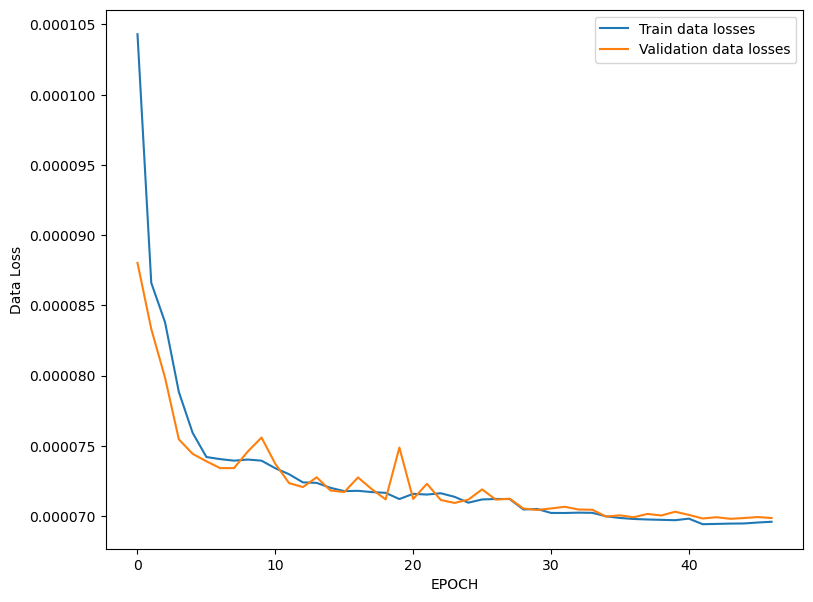

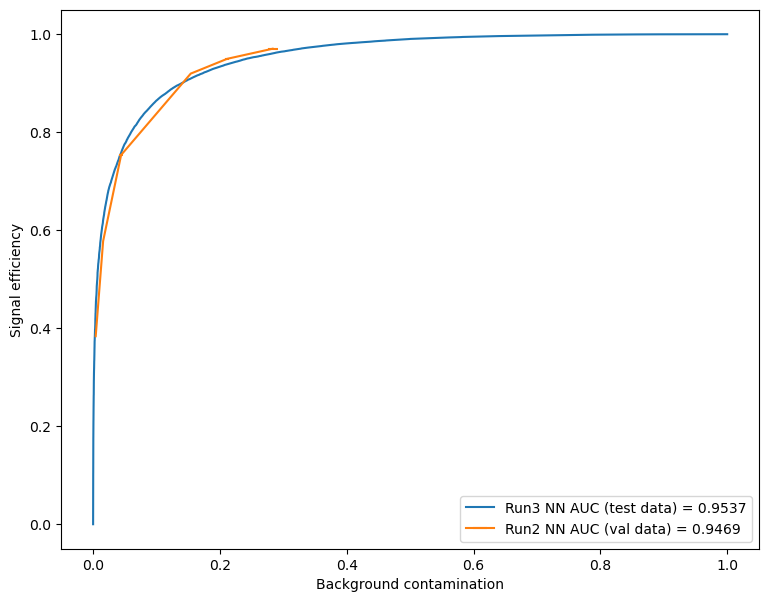

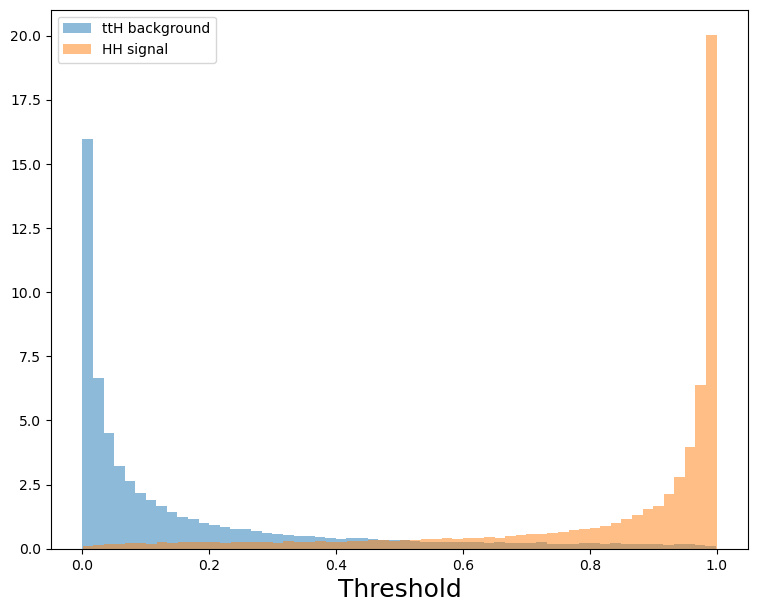

In [32]:
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0])] = value  

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]
TPR_thresholds = [0.97, 0.95, 0.92, 0.75, 0.57, 0.38]

fprs = []
base_tpr = np.linspace(0, 1, 5000)
thresholds = []
# volatile=True
best_batch_size = bestconf['batch_size']
# for train_index, test_index in skf.split(data_hlf, label):
val_loader = DataLoader(ParticleHLF(data_list_test, data_hlf_test, label_test), batch_size=bestconf['batch_size'], shuffle=False)
model.eval()
all_pred = np.zeros(shape=(len(data_hlf_test),2))
all_label = np.zeros(shape=(len(data_hlf_test)))
criterion= nn.NLLLoss()

with torch.no_grad():
    for batch_idx, (particles_data, hlf_data, y_data) in enumerate(val_loader):
        particles_data = particles_data.numpy()
        arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in the whole batch
        arr = [1 if x==0 else x for x in arr]
        arr = np.array(arr)
        sorted_indices_la= np.argsort(-arr)
        particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
        hlf_data = hlf_data[sorted_indices_la]
        particles_data = Variable(particles_data).cuda()
        hlf_data = Variable(hlf_data).cuda()
        # particles_data = Variable(particles_data)
        # hlf_data = Variable(hlf_data)
        t_seq_length= [arr[i] for i in sorted_indices_la]
        particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)

        outputs = model(particles_data, hlf_data)

        # Unsort the predictions (to match the original data order)
        # https://stackoverflow.com/questions/34159608/how-to-unsort-a-np-array-given-the-argsort
        b = np.argsort(sorted_indices_la)
        unsorted_pred = outputs[b].data.cpu().numpy()

        fill_array(all_pred, unsorted_pred, batch_idx, best_batch_size)
        fill_array(all_label, y_data.numpy(), batch_idx, best_batch_size)

fpr, tpr, threshold = roc_curve(all_label, np.exp(all_pred)[:,1])

fpr = np.interp(base_tpr, tpr, fpr)
threshold = np.interp(base_tpr, tpr, threshold)
fpr[0] = 0.0
fprs.append(fpr)
thresholds.append(threshold)

thresholds = np.array(thresholds)
mean_thresholds = thresholds.mean(axis=0)

fprs = np.array(fprs)
mean_fprs = fprs.mean(axis=0)
std_fprs = fprs.std(axis=0)
fprs_right = np.minimum(mean_fprs + std_fprs, 1)
fprs_left = np.maximum(mean_fprs - std_fprs,0)

mean_area = auc(mean_fprs, base_tpr)

print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(base_tpr>TPR_threshold)
    NNtable.add_row([mean_thresholds[thres_idx], base_tpr[thres_idx], "{:.4f} +/- {:.4f}".format(mean_fprs[thres_idx], std_fprs[thres_idx])])
print(NNtable)

plt.figure(figsize=(9,7))
plt.plot(range(len(train_losses)), train_losses, label="Train data losses")
plt.plot(range(len(train_losses)), val_losses, label="Validation data losses")
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('EPOCH')
plt.ylabel('Data Loss')

# plt.figure(figsize=(9,7))
# plt.plot(range(EPOCHS), val_losses, label="val losses vs. epoch")
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
# plt.legend(loc='best')
# plt.xlabel('EPOCH')
# plt.ylabel('Validation data Loss')

run2_sigEff = [.9704, .9498, .9196, .7536, .5777, .3837]
run2_bkgCont = [.2831, .2114, .1539, .0442, .0158, .0041]
run2_bkgCont_err = [.0077, .0036, .0011, .0032, .0006, .0001]
plt.figure(figsize=(9,7))
plt.plot(mean_fprs, base_tpr,label="Run3 NN AUC (test data) = %.4f" % mean_area)
plt.errorbar(run2_bkgCont, run2_sigEff, xerr=run2_bkgCont_err, label="Run2 NN AUC (val data) = {}".format(0.9469))
# plt.fill_betweenx(base_tpr, fprs_left, fprs_right, color='grey', alpha=0.4)
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[all_label==0,1], bins=60, label='ttH background',alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[all_label==1,1], bins=60, label='HH signal', alpha=0.5, density=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)

with h5py.File("ReallyInclusive_ROC.h5","w") as out:
    out['FPR'] = mean_fprs
    out['dFPR'] = std_fprs
    out['TPR'] = base_tpr
    out['Thresholds'] = mean_thresholds
    print("Saved ROC.")


### On the whole dataset

In [ ]:
def fill_array(array_to_fill, value, index, batch_size):
    array_to_fill[index*batch_size:min((index+1)*batch_size, array_to_fill.shape[0]),...] = value

particles_val = np.concatenate((normed_sig_list, normed_bkg_list))
hlf_val = np.concatenate((normed_sig_hlf, normed_bkg_hlf))
y_val = np.concatenate((np.ones(len(normed_sig_hlf)),np.zeros(len(normed_bkg_hlf))))
print(particles_val.shape)
print(hlf_val.shape)
print(y_val.shape)

test_batch_size = 300

all_pred = np.zeros(shape=(len(y_val),2))
test_loader = DataLoader(ParticleHLF(particles_val, hlf_val, y_val), batch_size = test_batch_size, shuffle=False)

model.eval()
# volatile=True

with torch.no_grad():
    for batch_idx, (particles_data, hlf_data, y_data) in enumerate(test_loader):
        particles_data = particles_data.numpy()
        arr = np.sum(particles_data!=0, axis=1)[:,0] # the number of particles in the whole batch
        arr = [1 if x==0 else x for x in arr]
        arr = np.array(arr)
        sorted_indices_la= np.argsort(-arr)
        particles_data = torch.from_numpy(particles_data[sorted_indices_la]).float()
        hlf_data = hlf_data[sorted_indices_la]
        particles_data = Variable(particles_data).cuda()
        hlf_data = Variable(hlf_data).cuda()
        # particles_data = Variable(particles_data)
        # hlf_data = Variable(hlf_data)
        t_seq_length= [arr[i] for i in sorted_indices_la]
        particles_data = torch.nn.utils.rnn.pack_padded_sequence(particles_data, t_seq_length, batch_first=True)
    
        outputs = model(particles_data, hlf_data)
    
        # Unsort the predictions (to match the original data order)
        # https://stackoverflow.com/questions/34159608/how-to-unsort-a-np-array-given-the-argsort
        b = np.argsort(sorted_indices_la)
        unsorted_pred = outputs[b].data.cpu().numpy()
        fill_array(all_pred, unsorted_pred, batch_idx, test_batch_size)
    
fpr, tpr, thresholds = roc_curve(y_val, np.exp(all_pred)[:,1])
area = auc(fpr, tpr)

TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5, 0.3]
print("Neural network performance")
NNtable = PrettyTable(['Threshold','Signal Efficiency','Background Contamination'])
NNtable.float_format = ".4"
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    NNtable.add_row([thresholds[thres_idx], tpr[thres_idx],  fpr[thres_idx]])
print(NNtable)
plt.figure(figsize=(9,7))
plt.plot(fpr,tpr,label="NN AUC = {}".format(area))
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
#plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
#plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[y_val==0,1], bins=60, label='ttH background',alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[y_val==1,1], bins=60, label='HH signal', alpha=0.5, density=True)
#plt.axvline(thresholds[thres_idx], ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)

sig_frame = pd.DataFrame.from_records(pandas_samples['sig'])
bkg_frame = pd.DataFrame.from_records(pandas_samples['bkg'])

sig_frame['NN_score'] = pd.Series(np.exp(all_pred[:len(normed_sig_hlf),1]), index=sig_frame.index)
bkg_frame['NN_score'] = pd.Series(np.exp(all_pred[len(normed_sig_hlf):,1]), index=bkg_frame.index)

### Check mistagged samples

In [ ]:
# https://stats.stackexchange.com/questions/261008/deep-learning-how-do-i-know-which-variables-are-important

In [ ]:
features_to_check = {
    'puppiMET_sumEt': [40, 0, 2500],
    'puppiMET_pt': [40, 0, 500],
    'puppiMET_eta': [40, -5, 5],
    'puppiMET_phi': [40, -3.15, 3.15],
    'DeltaPhi_j1MET': [40, -3.15, 3,15],
    'DeltaPhi_j2MET': [40, -3.15, 3,15],
    'DeltaR_jg_min': [40, 0, 5],
    'n_jets': [12, 0, 12],
    'chi_t0': [40, 0, 1000],
    'chi_t1': [40, 0, 1000],
    'lepton1_pt': [40, 0, 500],
    'lepton2_pt': [40, 0, 500],
    # 'ptmu1': [40, 0, 500],
    # 'ptmu2': [40, 0, 500],
    'pt': [40, 0, 1500],
    'lepton1_eta': [40, -5, 5],
    'lepton2_eta': [40, -5, 5],
    # 'etamu1': [40, -3.15, 3.15],
    # 'etamu2': [40, -3.15, 3.15],
    'eta': [40, -5, 5],
    'lepton1_phi': [40, -3.15, 3.15],
    'lepton2_phi': [40, -3.15, 3.15],
    # 'phimu1': [40, -3.15, 3.15],
    # 'phimu2': [40, -3.15, 3.15],
    'phi': [40, -3.15, 3.15],
    'abs_CosThetaStar_CS': [40, 0, 1],
    'abs_CosThetaStar_jj': [40, 0, 1]
}

# print(thresholds)
background_mistag_thres = thresholds[np.argmax(fpr>0.005)]
signal_mistag_thres = thresholds[np.argmax(tpr>0.97)]
print("Threshold for bkg mistag: {}".format(background_mistag_thres))
print("Threshold for signal mistag: {}".format(signal_mistag_thres))

plt.figure(figsize=(9,7))
plt.hist(np.exp(all_pred)[y_val==0,1], bins=60, label='ttH background',alpha=0.5, density=True)
plt.hist(np.exp(all_pred)[y_val==1,1], bins=60, label='HH signal', alpha=0.5, density=True)
plt.axvline(background_mistag_thres, ls='--',color='tab:gray')
plt.axvline(signal_mistag_thres, ls='--',color='tab:gray')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=18)


for feat in features_to_check:

    plt.figure(figsize=(8,6))
    plt.hist(bkg_frame[feat], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             label='Full background',
             histtype='stepfilled',
             alpha=0.4,
             density=True
             )
    plt.hist(sig_frame[feat], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
              label='Full signal',
              histtype='stepfilled',
             alpha=0.4,
             density=True,
            )
    plt.hist(sig_frame[feat][sig_frame['NN_score']<signal_mistag_thres], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             label='Signal predicted as bkg',
            histtype='step',
            linewidth=3,
             density=True,
            )
    plt.hist(bkg_frame[feat][bkg_frame['NN_score']>background_mistag_thres], bins=features_to_check[feat][0], 
             range=(features_to_check[feat][1], features_to_check[feat][2]),
             histtype='step',
             linewidth=3,
             label='Bkg predicted as signal',
             density=True
            )
    plt.xlabel(feat, fontsize=15)
    plt.yscale('log')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),
          ncol=2, fancybox=True, fontsize=14)


### Check mass sculpting

In [ ]:
fontsize=25

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame['dijet_mass'], bins=100, histtype='step', label='No cut',density=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_aux_frame['dijet_mass'][bkg_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', 
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             density=True)
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame['dijet_mass'], bins=100, histtype='step', label='No cut', density=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_aux_frame['dijet_mass'][sig_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             density=True)
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{bb}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(bkg_aux_frame['mass'], bins=100, range=(115,135), histtype='step', label='No cut', density=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(bkg_aux_frame['mass'][bkg_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, histtype='step', 
             range=(115,135),
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             density=True)
plt.legend(loc='best')
plt.ylabel('Background events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)

plt.figure(figsize=(9,6))
plt.hist(sig_aux_frame['mass'], bins=100, range=(115,135), histtype='step', label='No cut', density=True)
for TPR_threshold in TPR_thresholds:
    thres_idx = np.argmax(tpr>TPR_threshold)
    #print("NN Signal efficiency = {} @ {} ttH background contamination".format(tpr[thres_idx], fpr[thres_idx]))
    plt.hist(sig_aux_frame['mass'][sig_frame['NN_score']>thresholds[thres_idx]], 
             bins=100, 
             histtype='step', 
             range=(115,135),
             label= "{:.0f}% signal eff".format(100*tpr[thres_idx]),
             density=True)
plt.legend(loc='best')
plt.ylabel('Signal events',fontsize=fontsize)
plt.xlabel(r'$m_{\gamma \gamma}$',fontsize=fontsize)

### Benchmark

In [ ]:
with h5py.File("DNN_ROC.h5","r") as rocfile:
    fpr_dnn = rocfile['FPR'][:]
    dfpr_dnn = rocfile['dFPR'][:]
    tpr_dnn = rocfile['TPR'][:]
    thres_dnn = rocfile['Thresholds'][:]
    area_dnn = auc(fpr_dnn, tpr_dnn)
    fprs_dnn_right = np.minimum(fpr_dnn + dfpr_dnn, 1)
    fprs_dnn_left = np.maximum(fpr_dnn - dfpr_dnn,0)
    darea_dnn = (1-auc(tpr_dnn,fprs_dnn_left))-area_dnn
    
with h5py.File("BDT_ROC.h5","r") as rocfile:
    fpr_bdt = rocfile['FPR'][:]
    tpr_bdt = rocfile['TPR'][:]
    thres_bdt = rocfile['Thresholds'][:]
    area_bdt = auc(fpr_bdt, tpr_bdt)

with h5py.File("ReallyInclusive_ROC.h5","r") as rocfile:
    fpr_inc = rocfile['FPR'][:]
    dfpr_inc = rocfile['dFPR'][:]
    tpr_inc = rocfile['TPR'][:]
    thres_inc = rocfile['Thresholds'][:]
    area_inc = auc(fpr_inc, tpr_inc)
    fprs_inc_right = np.minimum(fpr_inc + dfpr_dnn, 1)
    fprs_inc_left = np.maximum(fpr_inc - dfpr_dnn,0)
    darea_inc = (1-auc(tpr_inc,fprs_inc_left))-area_inc

### Compare
plt.figure(figsize=(9,7))

plt.plot(fpr_bdt,tpr_bdt,color='blue',label="BDT AUC = {:.4f}".format(area_bdt))


plt.plot(fpr_dnn,tpr_dnn,color='green',label=r"VanillaDNN AUC = {:.4f}$\pm${:.4f}".format(area_dnn, darea_dnn))
plt.fill_betweenx(tpr_dnn, fprs_dnn_left, fprs_dnn_right, color='green', alpha=0.3)


plt.plot(fpr_inc,tpr_inc,color='orange',label=r"InclusiveNet AUC = {:.4f}$\pm${:.4f}".format(area_inc, darea_inc))
plt.fill_betweenx(tpr_inc, fprs_inc_left, fprs_inc_right, color='orange', alpha=0.3)

plt.xlabel('Background contamination',fontsize=18)
plt.ylabel('Signal efficiency',fontsize=18)
# # plt.xlim(0.01,0.6)
# # plt.ylim(0.2,1)
# plt.axhline(tpr[thres_idx],ls='--',color='tab:gray')
# plt.axvline(fpr[thres_idx],ls='--',color='tab:gray')
plt.legend(loc='best',fontsize=15)

In [ ]:
TPR_thresholds = [0.96, 0.935, 0.9, 0.7, 0.5]

table = PrettyTable(['Signal Efficiency','BDT','VanillaDNN','InclusiveNet'])
table.get_string(title="Background contamination at different signal efficiencies")
table.float_format = ".2"
for TPR_threshold in TPR_thresholds:
    thres_dnn = np.argmax(tpr_dnn>TPR_threshold)
    thres_bdt = np.argmax(tpr_bdt>TPR_threshold)
    thres_inc = np.argmax(tpr_inc>TPR_threshold)

    table.add_row(["{:.2f}%".format(100*(tpr_dnn[thres_dnn])),  "{:.2f}%".format(100*fpr_bdt[thres_bdt]), "({:.2f} +/- {:.2f})%".format(100*fpr_dnn[thres_dnn], 100*dfpr_dnn[thres_dnn]), "({:.2f} +/- {:.2f})%".format(100*fpr_inc[thres_inc], 100*dfpr_inc[thres_inc])])
print(table.get_string(title="Background contamination at different signal efficiencies"))

In [ ]:
features = [
    'puppiMET_sumEt', 'puppiMET_pt', 'puppiMET_eta', 'puppiMET_phi', # MET variables
    'DeltaPhi_j1MET', 'DeltaPhi_j2MET', # jet-MET variables
    'DeltaR_jg_min', 'n_jets', 'chi_t0', 'chi_t1', # jet variables
    'lepton1_pt' ,'lepton2_pt', 'pt', # lepton and diphoton pt
    'lepton1_eta', 'lepton2_eta', 'eta', # lepton and diphoton eta
    'lepton1_phi', 'lepton2_phi', 'phi', # lepton and diphoton phi
    'abs_CosThetaStar_CS', 'abs_CosThetaStar_jj' # angular variables
]

for fea in features:
    plt.figure()
    plt.hist(sig_frame[fea][sig_frame[fea]!=0], bins=40, density=True, 
             histtype='stepfilled', alpha=0.3, label='GluGluToHHTo2B2G Signal')
    plt.hist(bkg_frame[fea][bkg_frame[fea]!=0], bins=40, density=True, 
             histtype='stepfilled', alpha=0.45, label='ttHToGG Background')
    plt.xlabel(fea,fontsize=15)
    plt.legend(loc='best',fontsize=12)